In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as mcolors
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from kneed import KneeLocator
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler

In [3]:
def plot_data(x, y):
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, s=50)
    plt.xlabel('V1')
    plt.ylabel('V2')
    plt.show()

In [4]:
def plot_clusters(data, num_clusters, title):
    colors = list(mcolors.CSS4_COLORS.keys())

    for k in range(-1,num_clusters):
        rows = np.where(data[:, 2] == k)
        
        plt.scatter(data[rows][:, 0], data[rows][:, 1], label='Cluster {}'.format(k+1), color=colors[k])
    plt.legend()
    plt.xlabel('V1')
    plt.ylabel('V2')
    plt.title(title)
    plt.show()

In [5]:
def plot_silhouette_values(data, num_clusters, labels):
    sample_silhouette_values = silhouette_samples(data, labels)
    y_lower = 10
    for i in range(num_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = plt.cm.nipy_spectral(float(i) / num_clusters)
        plt.fill_betweenx(
            np.arange(y_lower, y_upper), 
            0, 
            ith_cluster_silhouette_values, 
            facecolor=color, 
            edgecolor=color, 
            alpha=0.7
        )
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    plt.title(f"Num Clusters: {num_clusters}")
    plt.show()

## Define DBSCAN Clustering

In [6]:
def evaluate_dbscan_clustering(data, min_pts, metric="silhouette"):
    dbscan_best_params = {"eps": 0, "min_pts": 0, "score": 0, "labels": None}
    score_history = {}

    if metric == 'davies_bouldin':
        dbscan_best_params['score'] = 1000
    if metric == 'silhouette':
        dbscan_best_params['score'] = -1000

    for minpt in min_pts:
        neighbors = NearestNeighbors(n_neighbors=minpt)
        neighbors_fit = neighbors.fit(data)

        distances, indices = neighbors_fit.kneighbors(data)
        distances = np.sort(distances, axis=0)
        distances = distances[:,1]
        indices = range(0, len(distances))
        plt.plot(indices, distances)
        plt.show()

        kneedle = KneeLocator(indices, distances, curve='convex', direction='increasing')
        eps = distances[kneedle.elbow]

        dbscan = DBSCAN(eps=eps, min_samples=minpt)
        y_pred = dbscan.fit_predict(data)
        k = len(set(y_pred)) - (1 if -1 in y_pred else 0)
        noise = list(y_pred).count(-1)
        
        
        if metric == 'davies_bouldin':
            score = davies_bouldin_score(data, y_pred)
            print(f"MinPts: {minpt}, Score: {score:.2f}")
            if score < dbscan_best_params["score"]:
                dbscan_best_params["eps"] = eps
                dbscan_best_params["min_pts"] = minpt
                dbscan_best_params["score"] = score
                dbscan_best_params["labels"] = y_pred
            
        if metric == 'silhouette':
            score = silhouette_score(data, y_pred)
            print(f"MinPts: {minpt}, Score: {score:.2f}")
            plot_silhouette_values(data, k, y_pred)
            if score > dbscan_best_params["score"]:
                dbscan_best_params["eps"] = eps
                dbscan_best_params["min_pts"] = minpt
                dbscan_best_params["score"] = score
                dbscan_best_params["labels"] = y_pred
        
        score_history[minpt] = score
    
    # Plot the score history
    plt.plot(list(score_history.keys()), list(score_history.values()))
    plt.xlabel('Min Points')
    plt.ylabel('Score')
    plt.show()

    return dbscan_best_params, score_history

## First Dataset

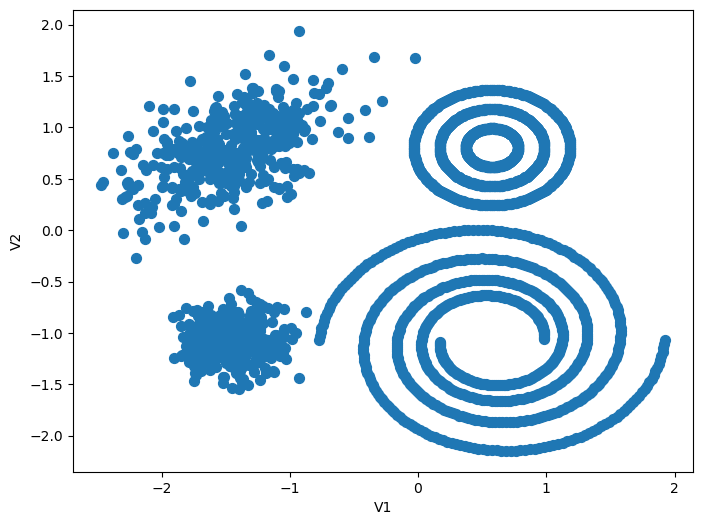

In [7]:
data_one = np.genfromtxt('donclassif.csv', delimiter=';')
data_one = np.delete(data_one, 0, 0)
data_one = StandardScaler().fit_transform(data_one)
plot_data(data_one[:, 0], data_one[:, 1])

### Find Number of Clusters using Silhouette Metric

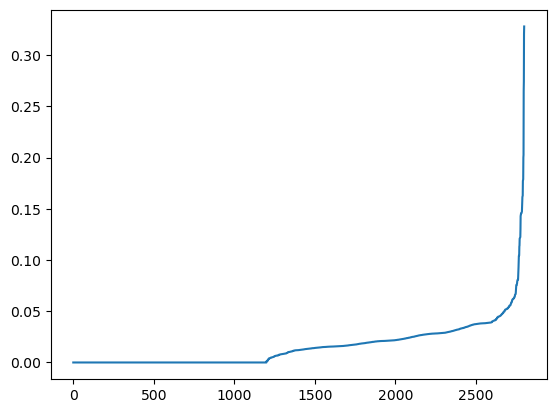

MinPts: 5, Score: 0.28


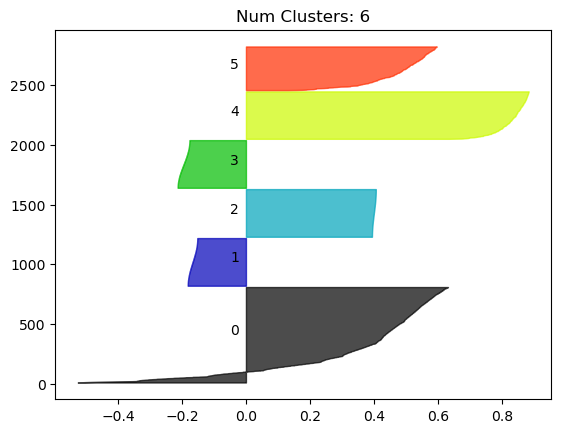

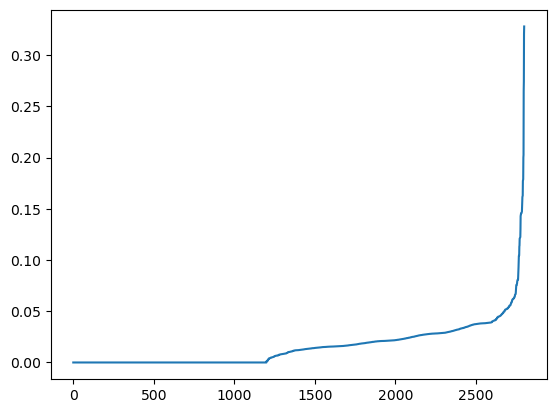

MinPts: 10, Score: 0.23


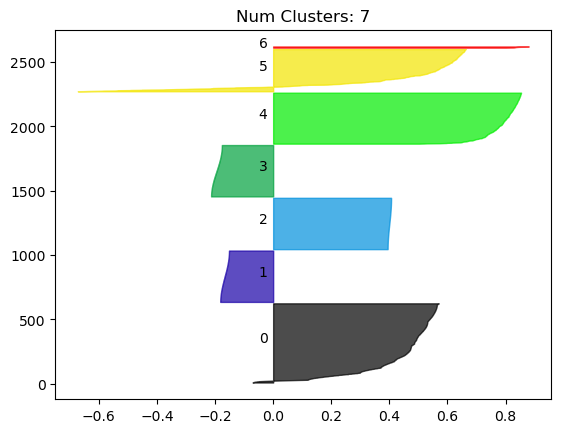

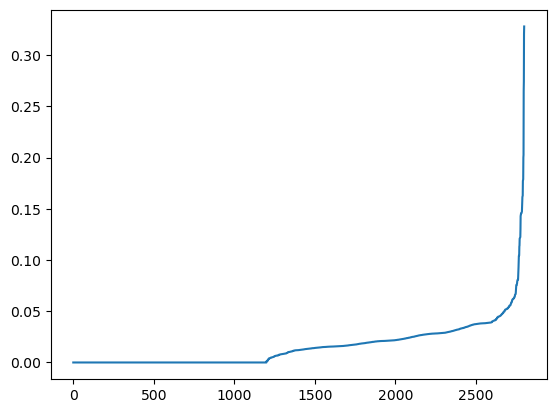

MinPts: 30, Score: 0.18


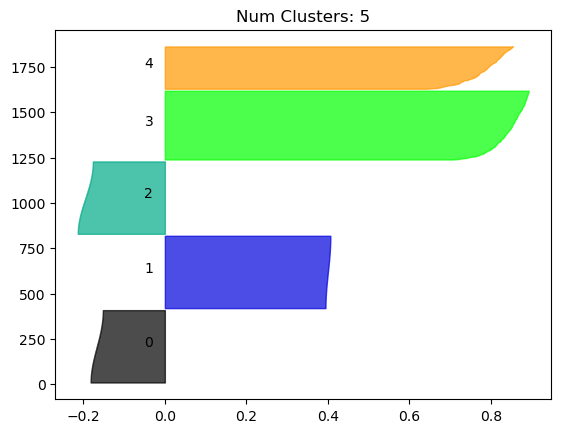

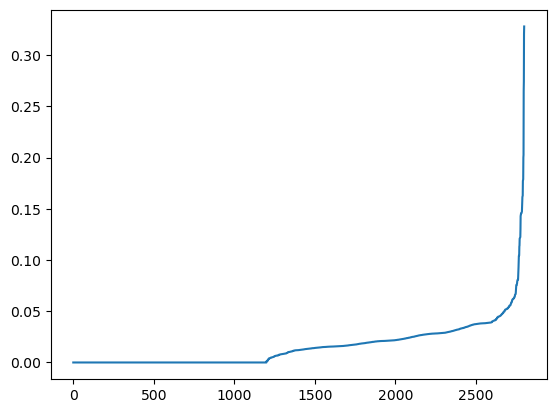

MinPts: 50, Score: -0.05


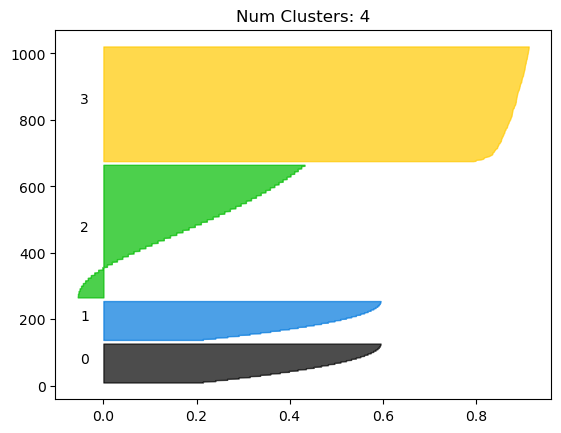

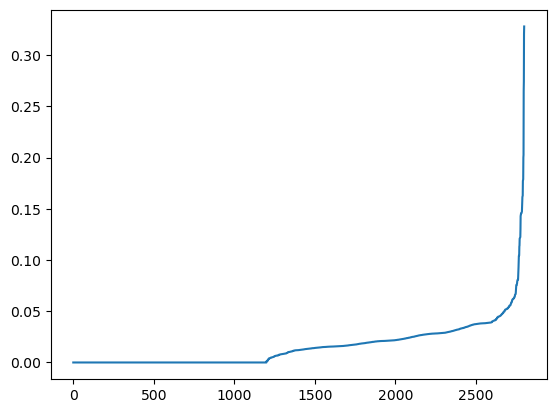

MinPts: 70, Score: -0.04


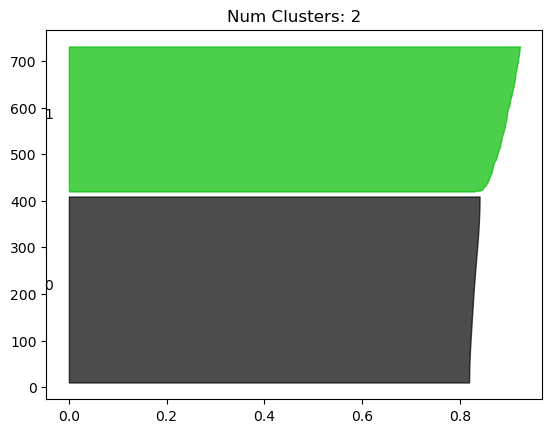

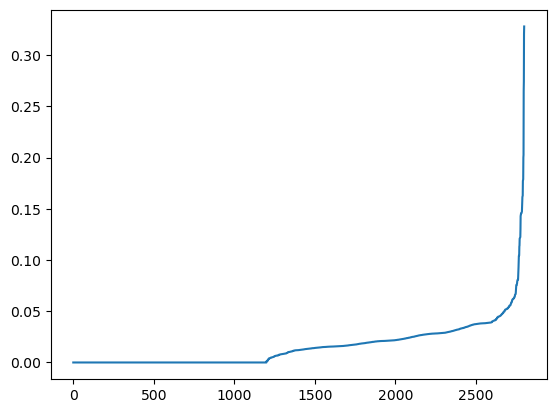

MinPts: 100, Score: -0.18


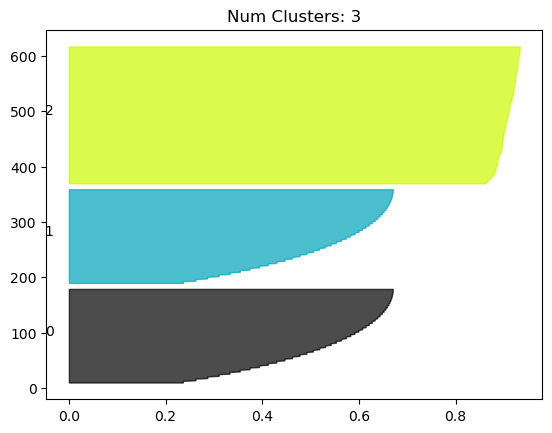

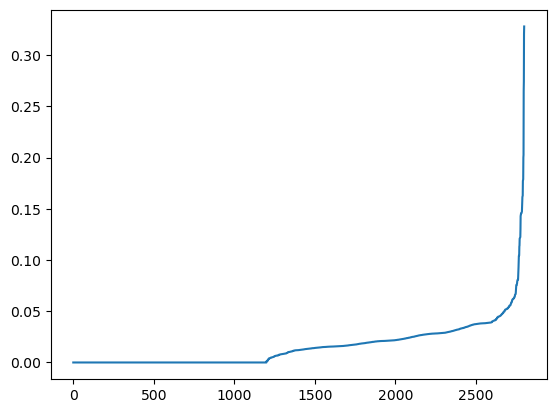

MinPts: 120, Score: 0.18


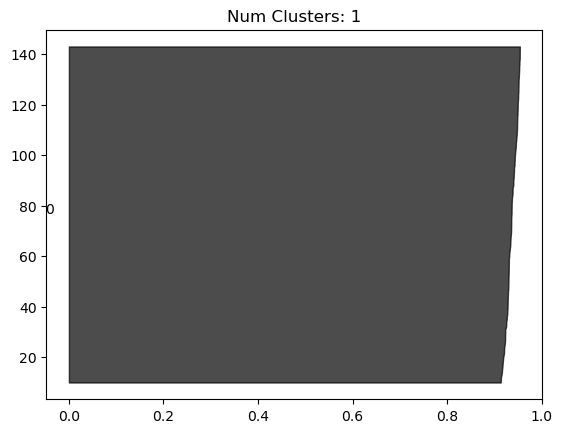

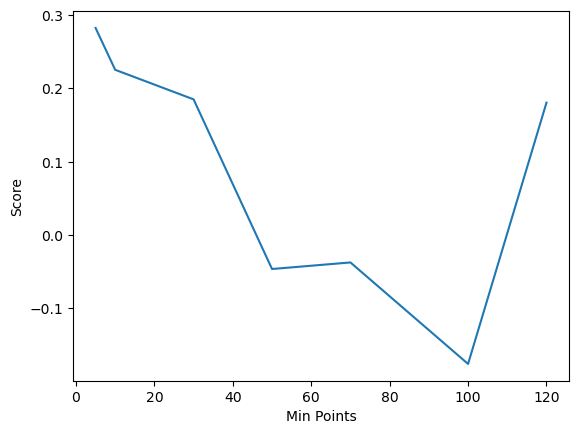

{'eps': 0.14589101673830662,
 'min_pts': 5,
 'score': 0.2823857235904524,
 'labels': array([0, 0, 0, ..., 5, 5, 5])}

In [8]:
min_pts = [5, 10, 30, 50, 70, 100, 120]
dbscan_best_params, dbscan_history = evaluate_dbscan_clustering(data_one,  min_pts=min_pts, metric='silhouette')
dbscan_best_params

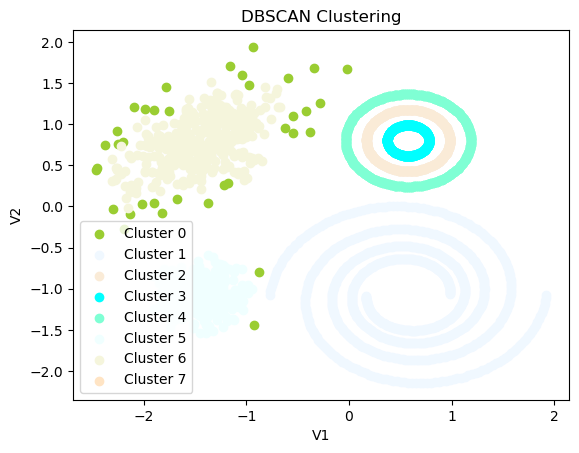

In [9]:
result_data_one = np.concatenate((data_one, dbscan_best_params['labels'].reshape(-1, 1)), axis=1)
plot_clusters(result_data_one, len(set(dbscan_best_params['labels'])), 'DBSCAN Clustering')

### Find Number of Clusters using Davies Bouldin Metric

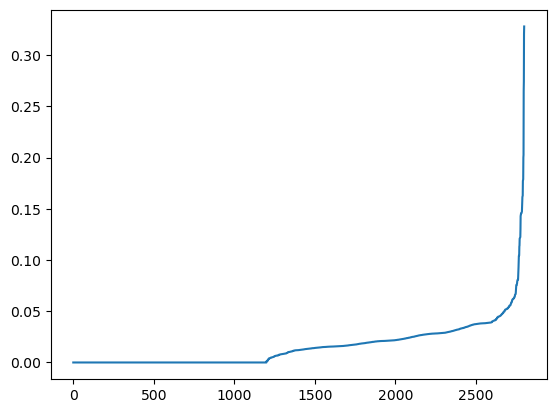

MinPts: 5, Score: 21209737.93


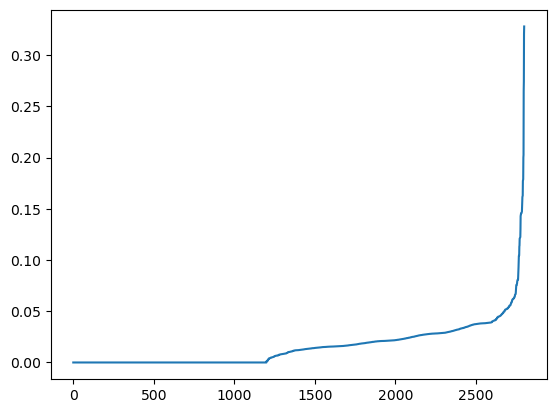

MinPts: 10, Score: 18558517.31


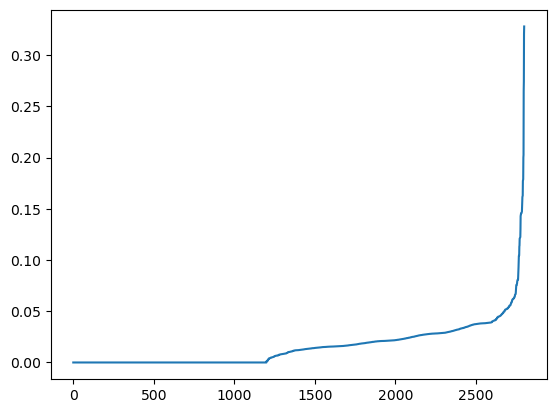

MinPts: 30, Score: 24744688.65


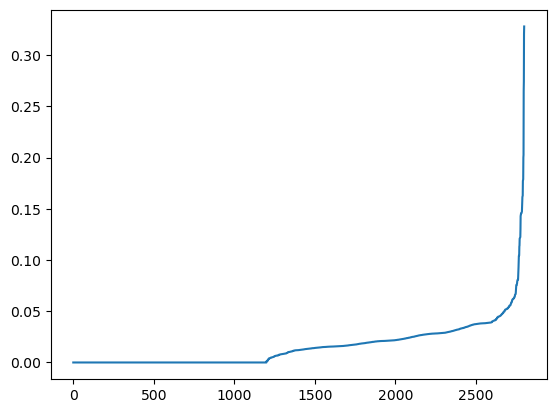

MinPts: 50, Score: 1.40


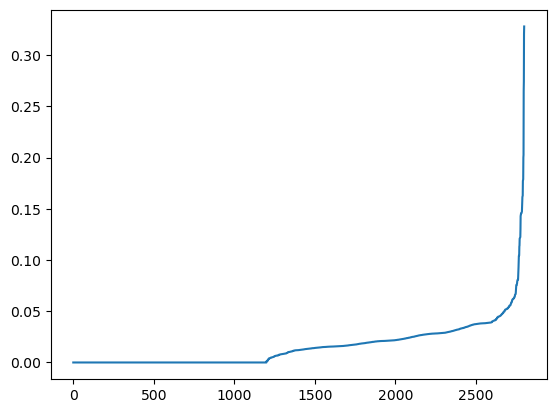

MinPts: 70, Score: 1.35


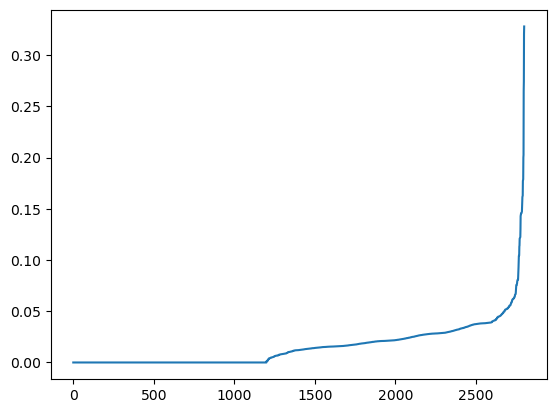

MinPts: 100, Score: 1.36


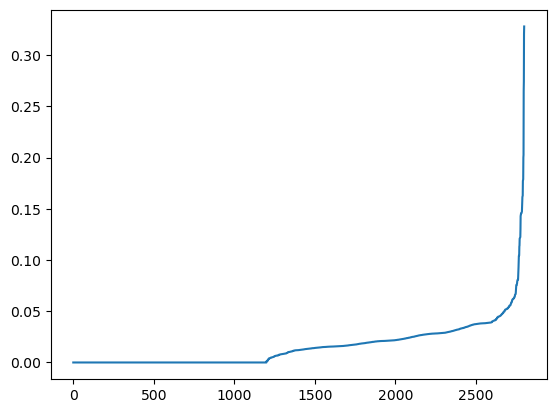

MinPts: 120, Score: 0.75


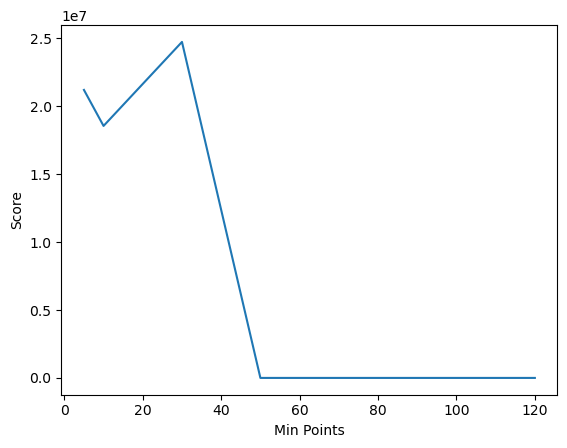

{'eps': 0.14589101673830662,
 'min_pts': 120,
 'score': 0.7463615327993474,
 'labels': array([-1, -1, -1, ..., -1, -1, -1])}

In [10]:
min_pts = [5, 10, 30, 50, 70, 100, 120]
dbscan_best_params, dbscan_history = evaluate_dbscan_clustering(data_one,  min_pts=min_pts, metric='davies_bouldin')
dbscan_best_params

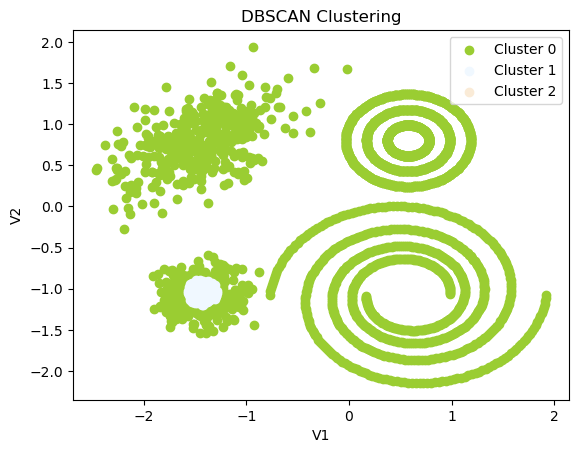

In [11]:
result_data_one = np.concatenate((data_one, dbscan_best_params['labels'].reshape(-1, 1)), axis=1)
plot_clusters(result_data_one, len(set(dbscan_best_params['labels'])), 'DBSCAN Clustering')

This occur because the Davies-Boulding index is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained from DBSCAN.

## Second Dataset

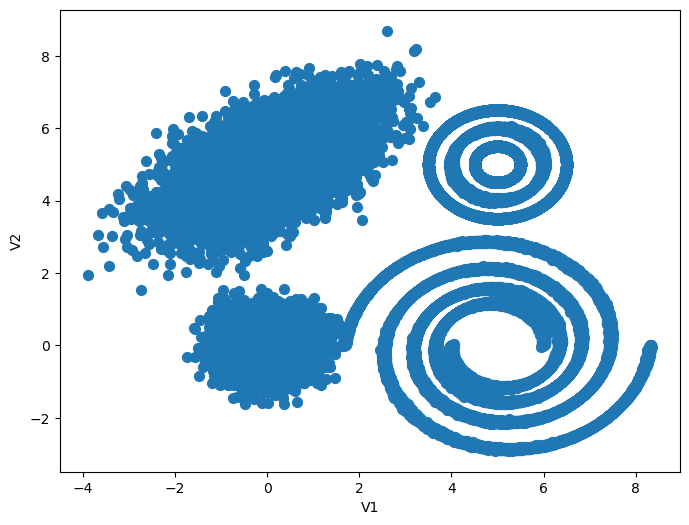

In [12]:
data_two = np.genfromtxt('donclassif2.csv', delimiter=';')
data_two = np.delete(data_two, 0, 0)
plot_data(data_two[:, 0], data_two[:, 1])

In [13]:
kmeans = KMeans(n_clusters=500, random_state=42).fit(data_two)
reduced_data_two = kmeans.cluster_centers_

### Find Number of Clusters using Silhouette Metric

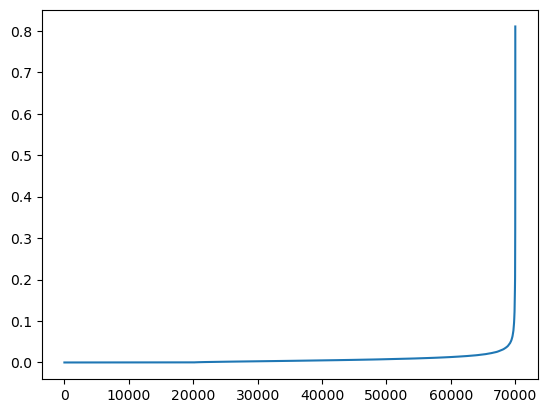

MinPts: 5, Score: -0.04


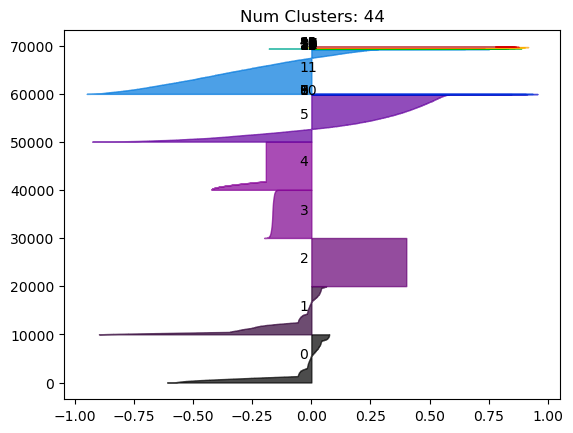

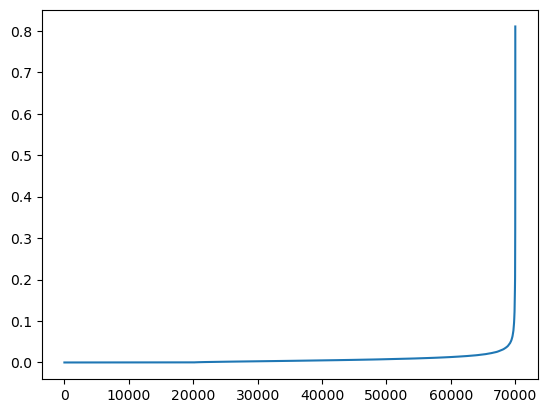

MinPts: 10, Score: -0.01


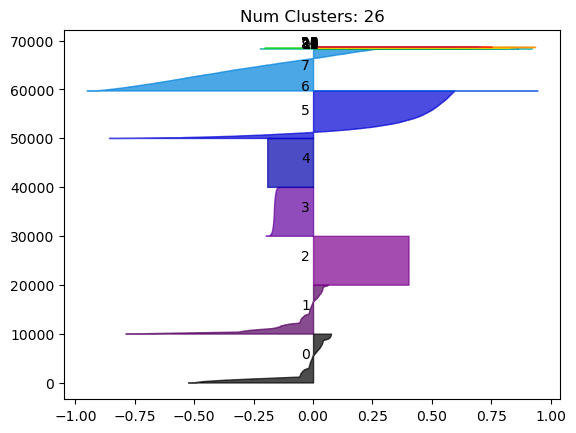

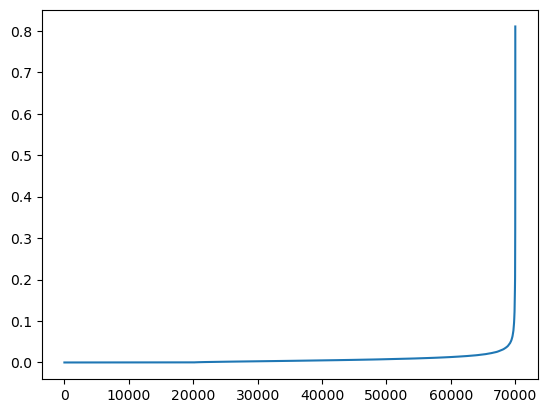

MinPts: 30, Score: 0.13


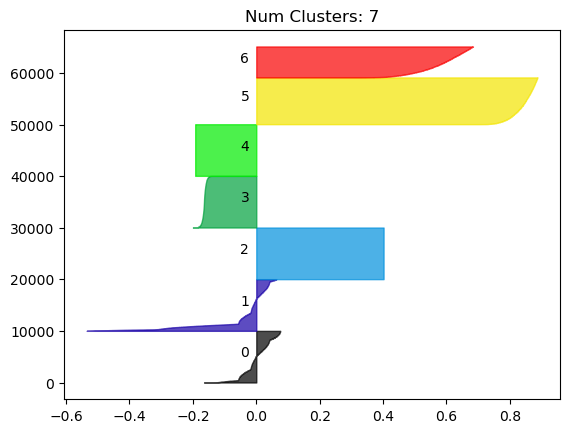

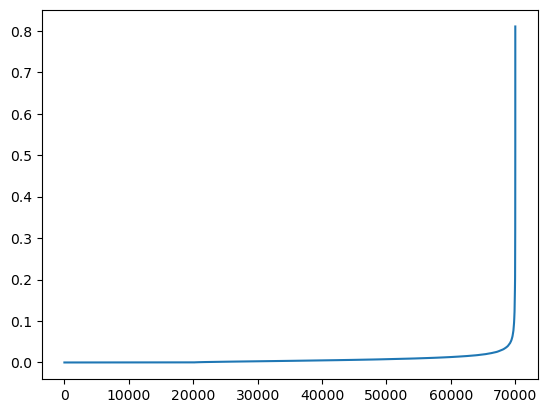

MinPts: 50, Score: -0.08


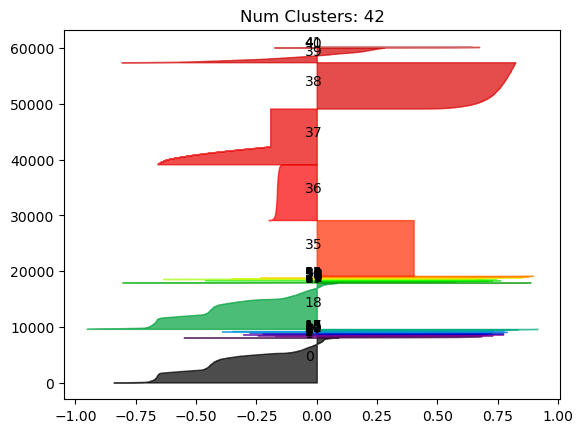

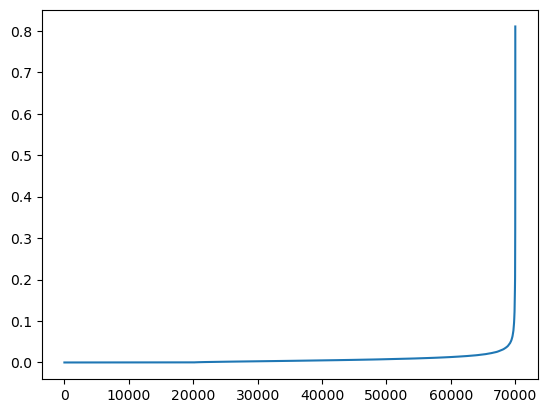

MinPts: 70, Score: -0.19


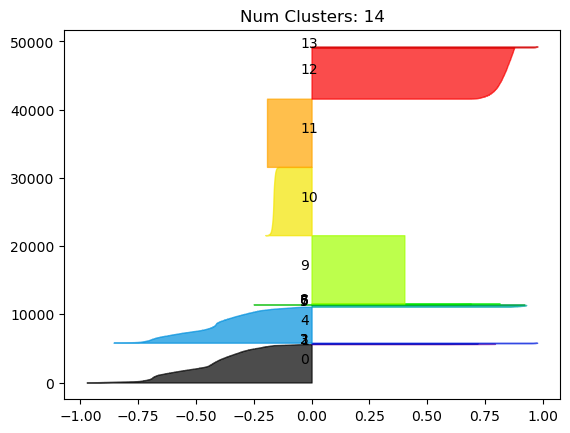

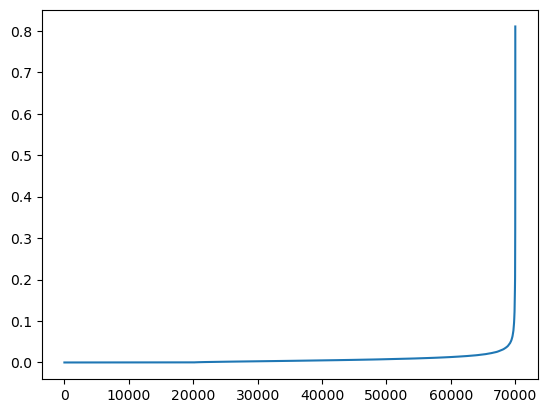

MinPts: 100, Score: -0.13


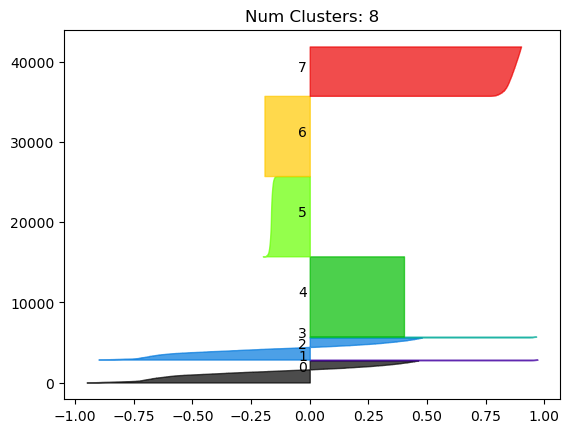

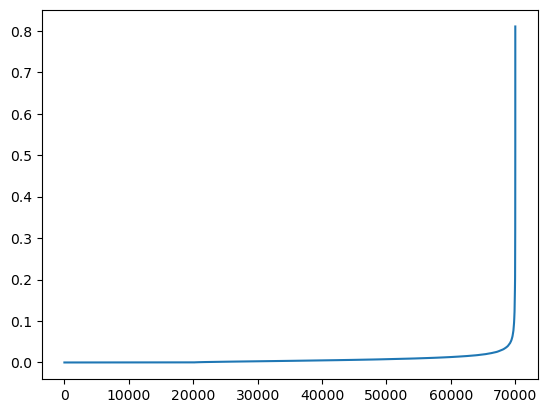

MinPts: 120, Score: -0.16


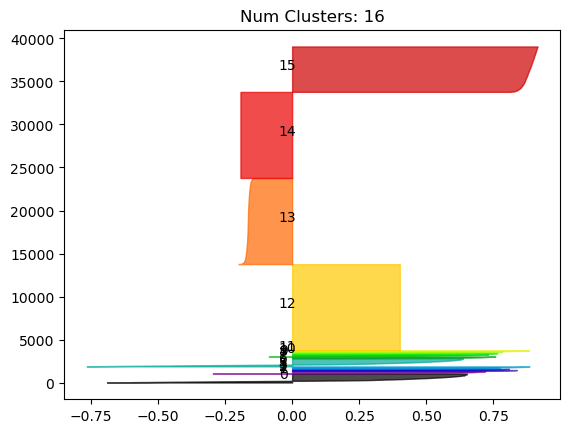

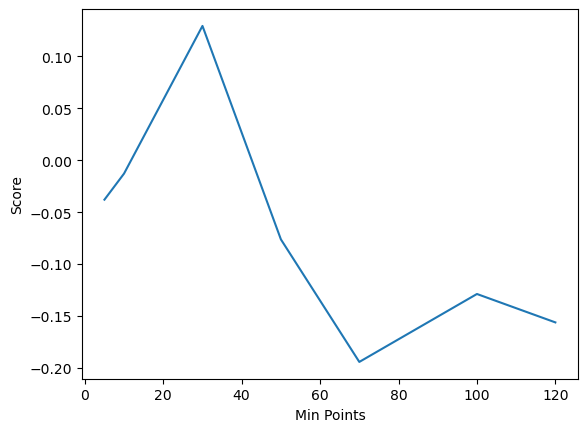

{'eps': 0.08794685676619461,
 'min_pts': 30,
 'score': 0.12931704180277492,
 'labels': array([ 0,  0,  0, ..., -1,  6,  6])}

In [14]:
min_pts = [5, 10, 30, 50, 70, 100, 120]
dbscan_best_params, dbscan_history = evaluate_dbscan_clustering(data_two,  min_pts=min_pts, metric='silhouette')
dbscan_best_params

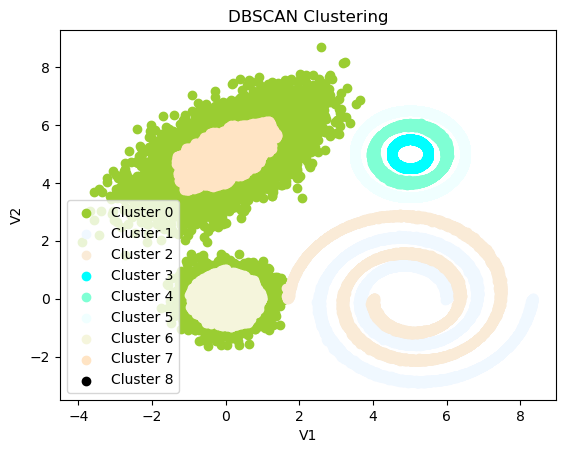

In [15]:
result_data_two = np.concatenate((data_two, dbscan_best_params['labels'].reshape(-1, 1)), axis=1)
plot_clusters(result_data_two, len(set(dbscan_best_params['labels'])), 'DBSCAN Clustering')

### Find Number of Clusters using Davies Bouldin Metric

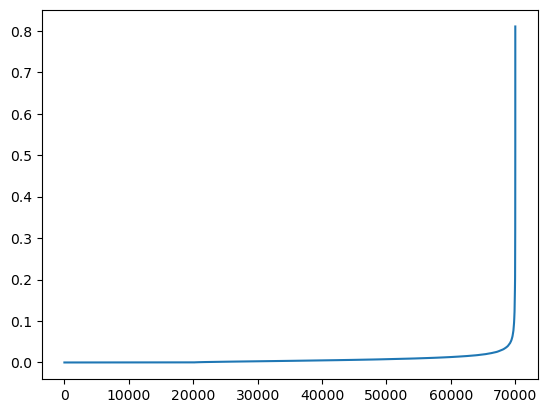

MinPts: 5, Score: 913.76


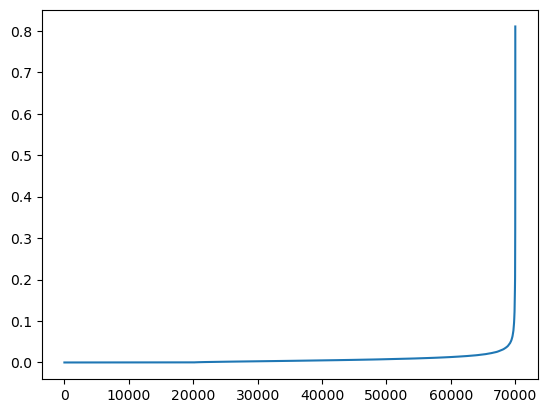

MinPts: 10, Score: 1521.89


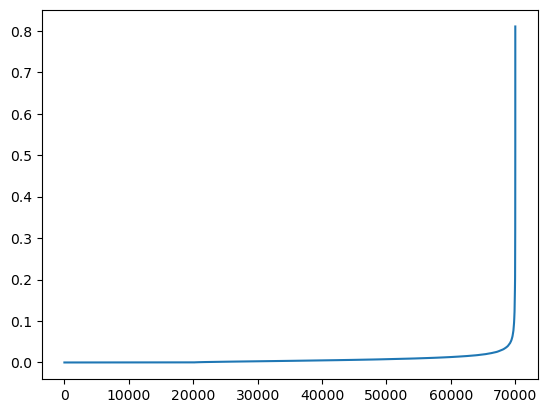

MinPts: 30, Score: 5132.08


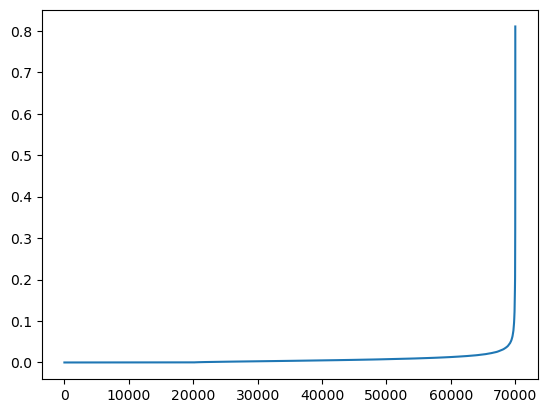

MinPts: 50, Score: 955.12


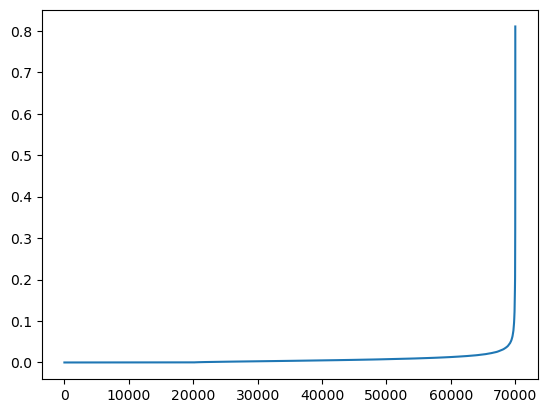

MinPts: 70, Score: 2737.04


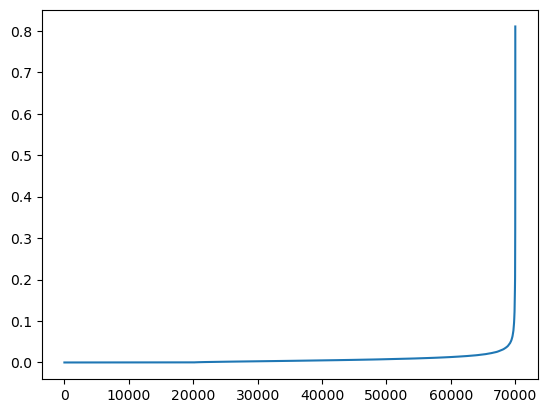

MinPts: 100, Score: 4559.64


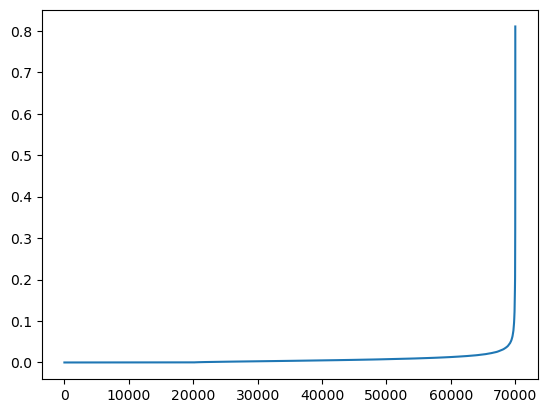

MinPts: 120, Score: 2414.63


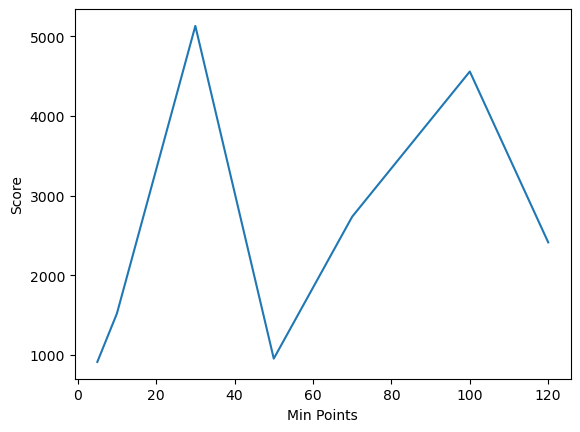

{'eps': 0.08794685676619461,
 'min_pts': 5,
 'score': 913.7612623160935,
 'labels': array([ 0,  0,  0, ..., 11, 11, 11])}

In [16]:
min_pts = [5, 10, 30, 50, 70, 100, 120]
dbscan_best_params, dbscan_history = evaluate_dbscan_clustering(data_two,  min_pts=min_pts, metric='davies_bouldin')
dbscan_best_params

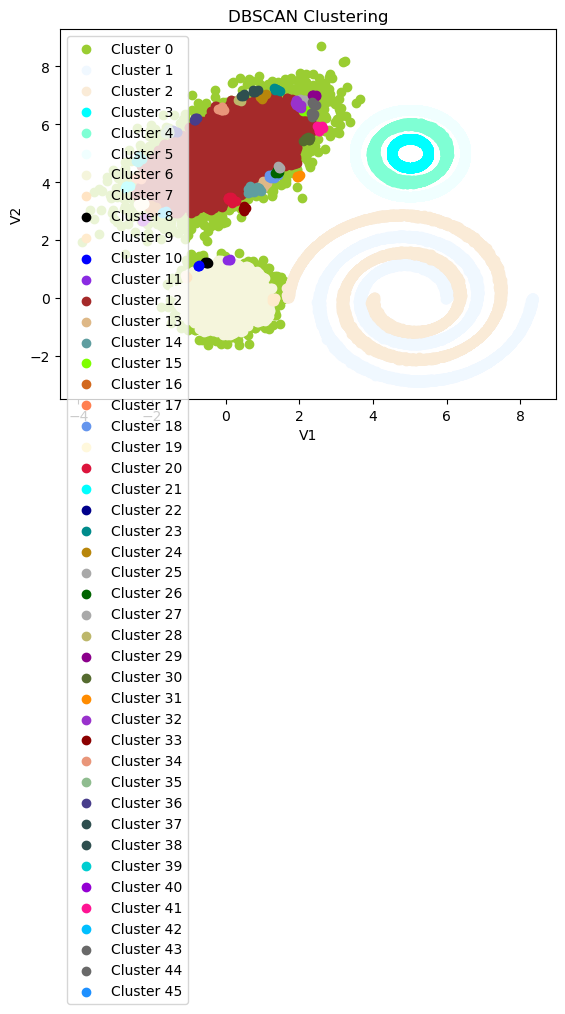

In [17]:
result_data_two = np.concatenate((data_two, dbscan_best_params['labels'].reshape(-1, 1)), axis=1)
plot_clusters(result_data_two, len(set(dbscan_best_params['labels'])), 'DBSCAN Clustering')